# K-Nearest Neighbors Classification

This notebook performs KNN classification using embeddings extracted from the Galaxy10 dataset with a ResNet-101 model pretrained on ImageNet.

We include:
- Grid search for best `k`
- Accuracy, balanced accuracy, precision, recall, F1
- Confusion matrix and per-class report
- Hierarchical class relation analysis

## Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px

## PCA on ResNet101 Embeddings

Applies PCA to reduce the dimensionality of the entire dataset using the precomputed ResNet101 embeddings.


In [42]:
# Load data
data = np.load('Galaxy10_Embedding_vectors/galaxy10_resnet101_embeddings_augmented_balanced.npz', allow_pickle=True)

# Separate train, val, and test
X_train = data['train_features']
y_train = data['train_labels']
X_val = data['val_features']
y_val = data['val_labels']
X_test = data['test_features']
y_test = data['test_labels']
class_names = data['class_names']

print(f"Original Train size: {X_train.shape[0]}")
print(f"Original Validation size: {X_val.shape[0]}")
print(f"Original Test size: {X_test.shape[0]}")
print(f"Original Embedding dimension: {X_train.shape[1]}")

# PCA to keep 95% variance (fit only on training data)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(f"Reduced Train dimension: {X_train_pca.shape[1]}")
print(f"Reduced Validation dimension: {X_val_pca.shape[1]}")
print(f"Reduced Test dimension: {X_test_pca.shape[1]}")


Original Train size: 48970
Original Validation size: 3269
Original Test size: 3268
Original Embedding dimension: 2048
Reduced Train dimension: 25
Reduced Validation dimension: 25
Reduced Test dimension: 25


## Grid Search for Optimal `k`

In [43]:
# Use only odd k values
k_values = list(range(1, 39, 2))
results = []

# Train on train set, validate on val set
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  # Only train set
    y_val_pred = knn.predict(X_val)  # Validate on val set
    acc = accuracy_score(y_val, y_val_pred)
    results.append({'k': k, 'accuracy': acc})

results_df = pd.DataFrame(results)

## Plot Accuracy

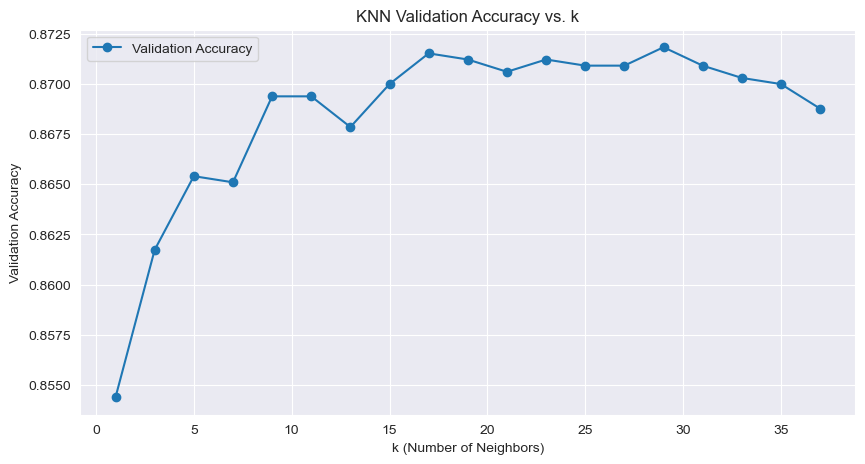

Best k (based on validation accuracy): 29


In [44]:
# Plot accuracy vs k
plt.figure(figsize=(10, 5))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='Validation Accuracy')
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Validation Accuracy")
plt.title("KNN Validation Accuracy vs. k")
plt.grid(True)
plt.legend()
plt.show()

# Find best k based on validation accuracy
best_k = results_df.loc[results_df['accuracy'].idxmax()]['k']
print(f"Best k (based on validation accuracy): {int(best_k)}")


## Evaluate KNN on Test Set

Trains the KNN classifier with the best `k` found on the training set, then evaluates it on the test set using accuracy, balanced accuracy, macro precision, recall, and F1 score.

In [45]:
# Train KNN with best k on the training set
knn = KNeighborsClassifier(n_neighbors=int(best_k))
knn.fit(X_train, y_train)  # Fit on training data

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate evaluation metrics on test set
acc = accuracy_score(y_test, y_pred)  # Standard accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)  # Accounts for class imbalance
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)  # Average precision across classes
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)  # Average recall across classes
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)  # Average F1 score across classes

# Print results
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bal_acc:.4f}")
print(f"Macro Precision:     {precision:.4f}")
print(f"Macro Recall:        {recall:.4f}")
print(f"Macro F1 Score:      {f1:.4f}")


Accuracy:            0.8807
Balanced Accuracy:   0.7550
Macro Precision:     0.7617
Macro Recall:        0.7550
Macro F1 Score:      0.7578


## Confusion Matrices

Displays two confusion matrices: one with raw counts and one with row-wise percentages for the test set predictions.


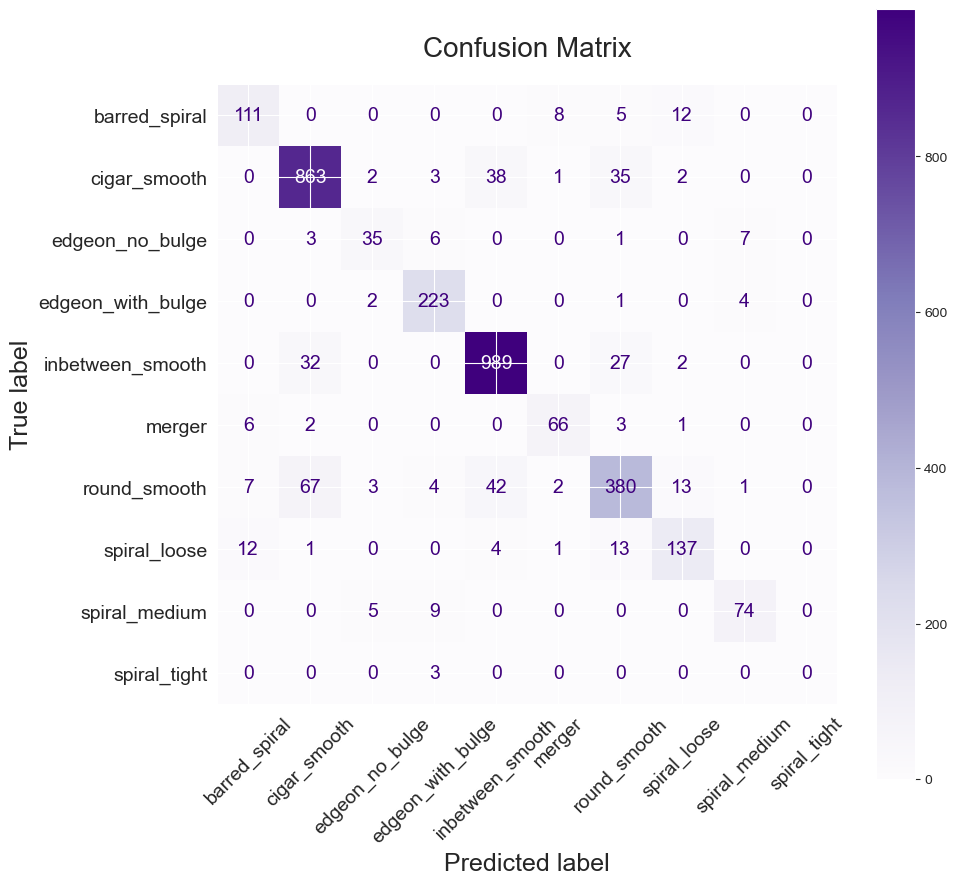

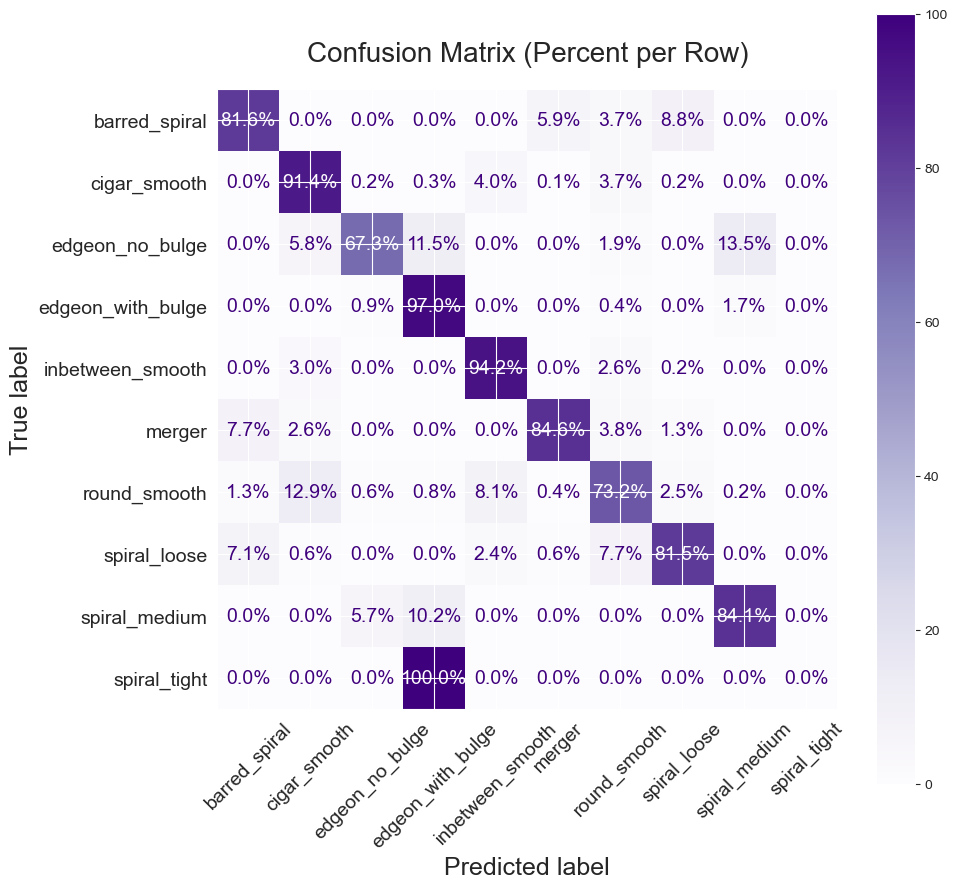

In [46]:
# Confusion matrix (raw counts)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Purples', xticks_rotation=45)

ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)
for text in disp.text_.ravel():
    text.set_fontsize(14)

plt.show()

# Confusion matrix (row-wise percentages)
cm_percent = cm.astype(float) / cm.sum(axis=1)[:, None] * 100
disp_percent = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp_percent.plot(ax=ax, cmap='Purples', xticks_rotation=45, values_format='.1f')

for text in disp_percent.text_.ravel():
    text.set_text(f"{float(text.get_text()):.1f}%")
    text.set_fontsize(14)

ax.set_title("Confusion Matrix (Percent per Row)", fontsize=20, pad=20)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.tick_params(axis='both', labelsize=14)

plt.show()

## Classification Report

Prints precision, recall, F1 score, and support for each class in the test set.


In [47]:
print(classification_report(y_test, y_pred, target_names=class_names, digits=4, zero_division=0))

                   precision    recall  f1-score   support

    barred_spiral     0.8162    0.8162    0.8162       136
     cigar_smooth     0.8915    0.9142    0.9027       944
  edgeon_no_bulge     0.7447    0.6731    0.7071        52
edgeon_with_bulge     0.8992    0.9696    0.9331       230
 inbetween_smooth     0.9217    0.9419    0.9317      1050
           merger     0.8462    0.8462    0.8462        78
     round_smooth     0.8172    0.7322    0.7724       519
     spiral_loose     0.8204    0.8155    0.8179       168
    spiral_medium     0.8605    0.8409    0.8506        88
     spiral_tight     0.0000    0.0000    0.0000         3

         accuracy                         0.8807      3268
        macro avg     0.7617    0.7550    0.7578      3268
     weighted avg     0.8781    0.8807    0.8788      3268



## Hierarchical Clustering of Predicted Classes

We analyzed how the model groups Galaxy10 classes by performing hierarchical clustering based on the **mean embedding** (centroid) of each **predicted class** in the test set.

For each class that was actually predicted by the model, we computed its centroid by averaging the embeddings of all test samples assigned to that class. This approach reflects how the model internally organizes its predictions in feature space.

We used **Ward’s method** on the pairwise **Euclidean distances** between class centroids:

$$
\text{Distance}(C_i, C_j) = \left\| \mu_i - \mu_j \right\|_2
$$

This method reveals how semantically close the predicted classes are according to the model’s learned representation.

> Note: Classes not predicted at all are excluded from the dendrogram.

Skipping class spiral_tight: no predictions in test set.


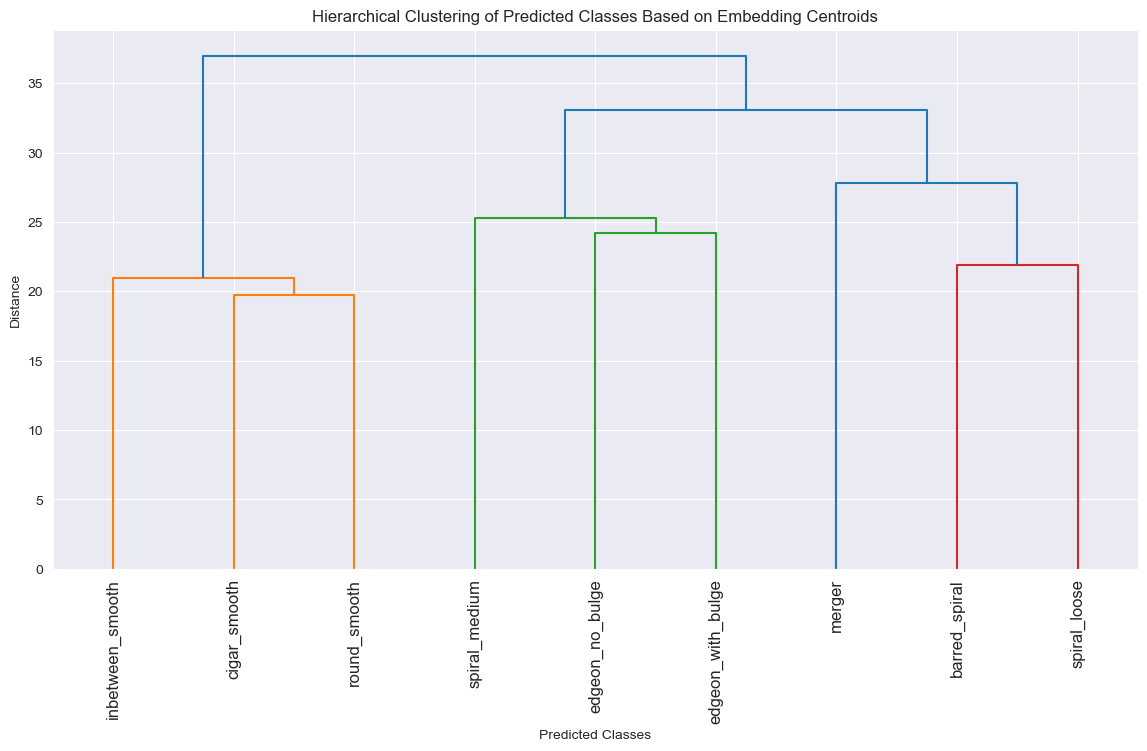

In [48]:
# Make sure class names are a numpy array
class_names = np.array(class_names)

# Find the unique classes predicted by the model
predicted_classes = np.unique(y_pred)

centroids_pred = []
valid_class_names_pred = []

for cls in range(len(class_names)):
    idx = np.where(y_pred == cls)[0]

    if len(idx) == 0:
        print(f"Skipping class {class_names[cls]}: no predictions in test set.")
        continue
    else:
        centroid = np.mean(X_test[idx], axis=0)
        centroids_pred.append(centroid)
        valid_class_names_pred.append(class_names[cls])

centroids_pred = np.array(centroids_pred)
valid_class_names_pred = np.array(valid_class_names_pred)

# Perform hierarchical clustering
linked_pred = linkage(centroids_pred, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linked_pred, labels=valid_class_names_pred, leaf_rotation=90)
plt.title('Hierarchical Clustering of Predicted Classes Based on Embedding Centroids')
plt.xlabel('Predicted Classes')
plt.ylabel('Distance')
plt.show()